# Feathering

[This talk](FeatheringPresentation.ipynb) can be found at http://small.cat/hat until next week.  Please follow along on your laptop or phone.

Goals:

 * Describe and demonstrate feathering process
 * Show some of the free parameters that can be selected when feathering
 * Show various visualizations that can be used to assess goodness-of-merge
     * PSD plots
     * Residuals from theoretical
 * Demonstrate limitations of image combination
 * Show tools for simulating realistic synthetic data

## What is feathering?

Fourier-space (UV-space) weighted averaging of two data sets.

The weight function is selected to match the Fourier transform of the single-dish telescope's beam.

## Benefits & Costs of feathering

The good:

 * Simple
 * Applicable to non-interferometer (e.g., bolometer + other) data
 
The bad:

 * _Deceptively_ simple
 * Ignores spectral information (see SDINT, TP2VIS talks)
 * Does not fix interferometric image reconstruction problems
 * Tricky to balance weights for correctness vs optimal noise

# radio-astro-tools

http://radio-astro-tools.github.io

Includes tools for cubes (https://spectral-cube.readthedocs.io), beam metadata handling (https://github.com/radio-astro-tools/radio-beam), and feathering (https://github.com/radio-astro-tools/uvcombine/)

# Feathering (combination) tests

This notebook presents a series of experiments in single-dish + interferometer combination on "realistic" data.

We're "observing" at 2mm, so a 12m dish has a FWHM=40" Gaussian beam and a 9m baseline has a sharp cutoff at 56"

This presentation deals mostly with idealized cases; there is no primary beam degradation included in the simulations.

In [1]:
# ipython notebook setup:
%matplotlib inline

In [2]:
# filter out warnings
# e.g., RuntimeWarning: divide by zero encountered in true_divide
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pylab as pl
pl.rcParams['image.interpolation'] = 'nearest'
pl.rcParams['image.origin'] = 'lower'
pl.rcParams['figure.figsize'] = (12,8)
pl.rcParams['image.cmap'] = 'viridis'
pl.rcParams['patch.edgecolor'] = 'none'
pl.rcParams['axes.prop_cycle'] = pl.cycler('color', ('#338ADD', '#9A44B6', '#A60628', '#467821', '#CF4457', '#188487', '#E24A33'))
pl.rcParams['font.size'] = 20

Requirements for this work: [``turbustat``](https://github.com/Astroua/TurbuStat/) generates our synthetic data and helps with power-spectral-density (PSD) plotting.  ``astropy.convolution`` provides access to convolution tools, and ``uvcombine`` is our python-only implementation of ``feather``.

https://turbustat.readthedocs.io/en/latest/, especially https://turbustat.readthedocs.io/en/latest/generating_test_data.html

In [4]:
from turbustat.simulator.gen_field import make_extended
from turbustat.statistics import psds
from astropy import convolution, units as u
import numpy as np
from uvcombine.uvcombine import feather_kernel, fftmerge

We create a synthetic power-law power-spectrum image.  This sort of image is typical of a dust image of the Galactic plane, for example.

In [5]:
# create an input image with specified parameters
# (this can later be modified - it will be good to examine the effects of
# different power laws, different types of input...)
# We're assuming a scale of 1"/pixel for this example
imsize = 512
powerlaw = 3
im = make_extended(imsize=imsize, powerlaw=powerlaw, randomseed=0)
# the real sky is positive, so we subtract the minimum to force the overall image positive
im = im - im.min()

### Input Image Visualization ###
This is the input image along with its histogram.

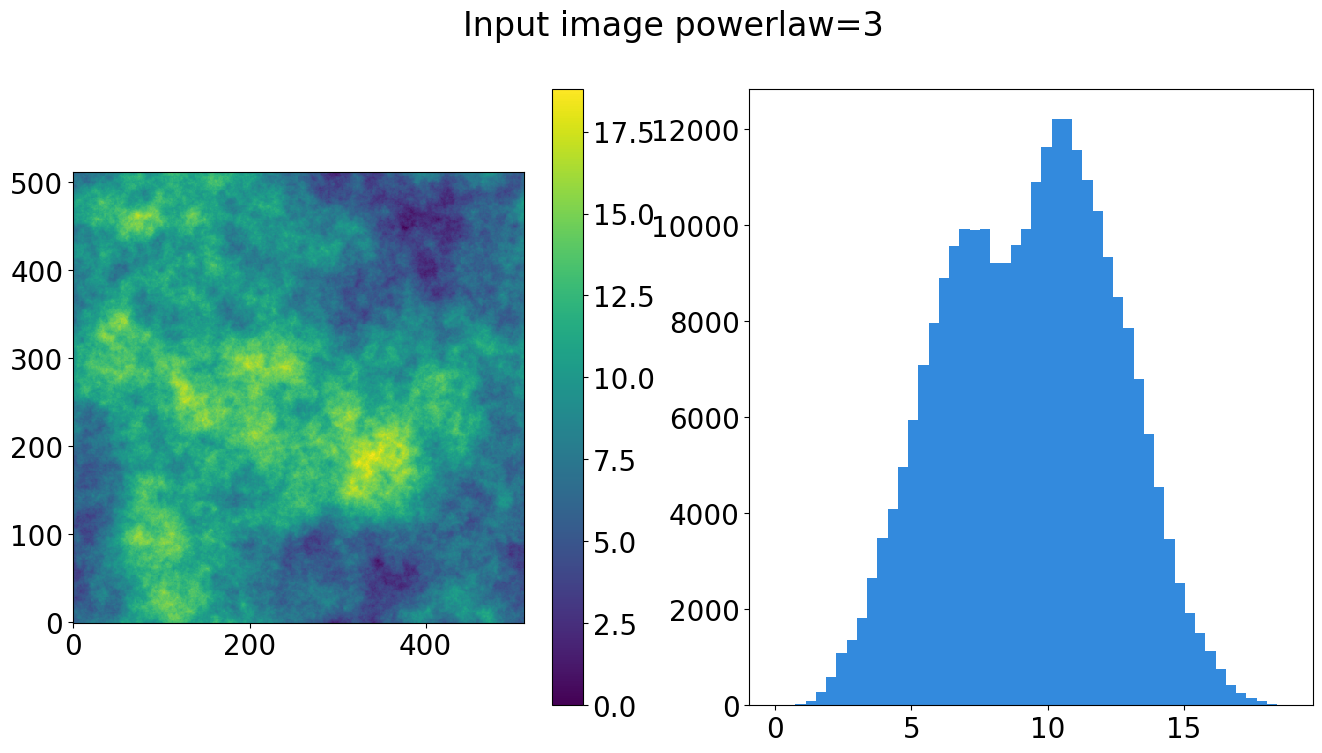

In [6]:
# for each step, we'll save a figure
pl.figure(1, figsize=(16,8)).clf()
pl.subplot(1,2,1)
pl.imshow(im, cmap='viridis')
pl.colorbar()
pl.subplot(1,2,2)
pl.hist(im.ravel(), bins=50)
pl.suptitle(f"Input image powerlaw={powerlaw}")
pl.savefig(f"inputimage_pl{powerlaw}.png")

The power spectrum of the input image (set to be $\alpha=3$), verifying that the turbustat code works

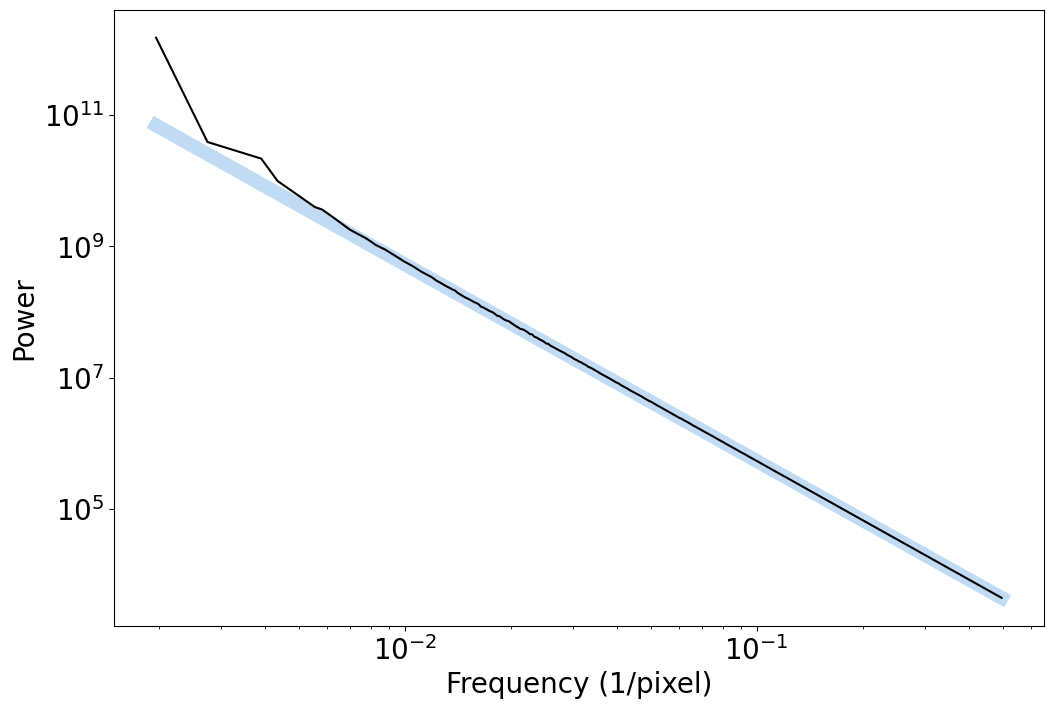

In [7]:
psd2 = np.fft.fftshift(np.abs(np.fft.fft2(im)**2))
pfreq, ppow = psds.pspec(psd2)
pl.loglog(pfreq, ppow[-1] * (pfreq/pfreq[-1])**-powerlaw, alpha=0.3, linewidth=10, zorder=-20)
pl.loglog(pfreq[np.isfinite(ppow)], ppow[np.isfinite(ppow)], color='k')
pl.ylabel("Power")
_=pl.xlabel("Frequency (1/pixel)")

Next, we create our simulated interferometer by creating a UV domain and selecting which pixels in that domain will be part of our telescope.  This process creates an ideal interferometer.

In [8]:
# set up the grid
ygrid, xgrid = np.indices(im.shape, dtype='float')
rr = ((xgrid-im.shape[1]/2)**2+(ygrid-im.shape[0]/2)**2)**0.5

In [9]:
# Create a UV sampling mask.
# This removes all large-angular scale (r<8) features *in UV space* and all
# small angular scales.
# In fourier space, r=0 corresponds to the DC component
# r=1 corresponds to the full map (one period over that map)
# r=256 is the smallest angular scale, which is 2 pixels
# We're assuming a pixel scale of 1" / pixel
# therefore 56" corresponds to 9m at 2mm (i.e., nearly the closest spacing possible for 7m)
# We cut off the "interferometer" at 2.5" resolution
largest_scale = 56.*u.arcsec
smallest_scale = 2.5*u.arcsec
pixscale = 1*u.arcsec
image_scale = im.shape[0]*pixscale # assume symmetric (default=256)
ring = (rr>=(image_scale/largest_scale)) & (rr<=(image_scale/smallest_scale))

### Synthetic Perfect Interferometer ###
The synthetic interferometer's UV coverage map (it's a perfect interferometer)

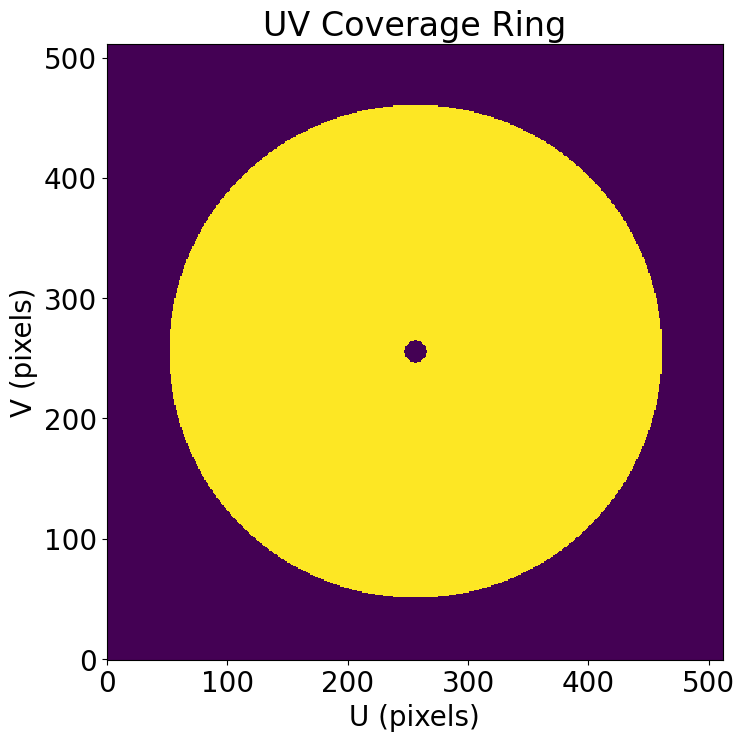

In [10]:
pl.clf()
pl.imshow(ring)
pl.title("UV Coverage Ring")
pl.xlabel("U (pixels)")
pl.ylabel("V (pixels)")
pl.savefig("uvcoverage_ring.png")

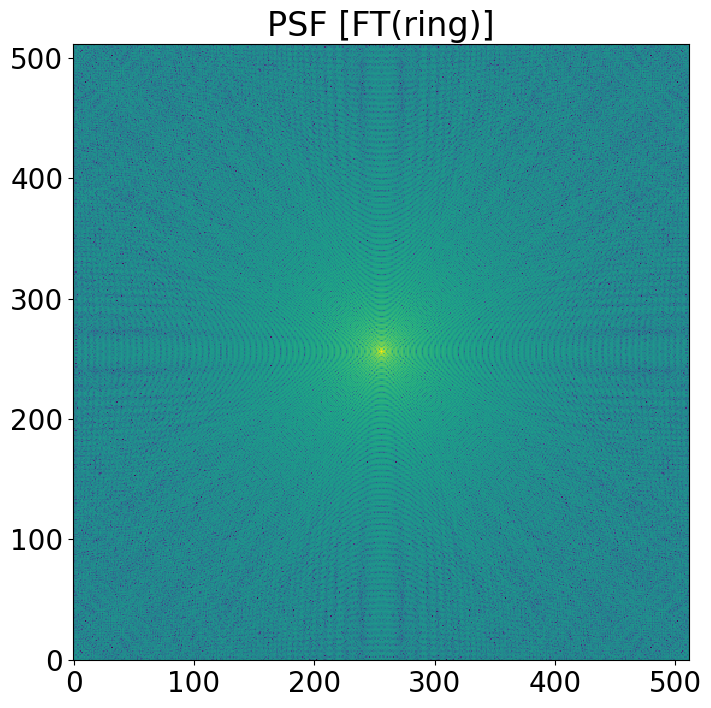

In [11]:
pl.imshow(np.abs(np.fft.fftshift(np.fft.fft2(ring))), norm=pl.matplotlib.colors.LogNorm())
_=pl.title("PSF [FT(ring)]")

Next, we create the interferometric map by multiplying our interferometer mask by the fourier transform of the sky data

In [12]:
# create the interferometric map by removing both large and small angular
# scales in fourier space
imfft = np.fft.fft2(im)
imfft_interferometered = imfft * np.fft.fftshift(ring)
im_interferometered = np.fft.ifft2(imfft_interferometered)

The interferometric image does not preserve total flux, as expected.  Note that the mean of the histogram is shifted.

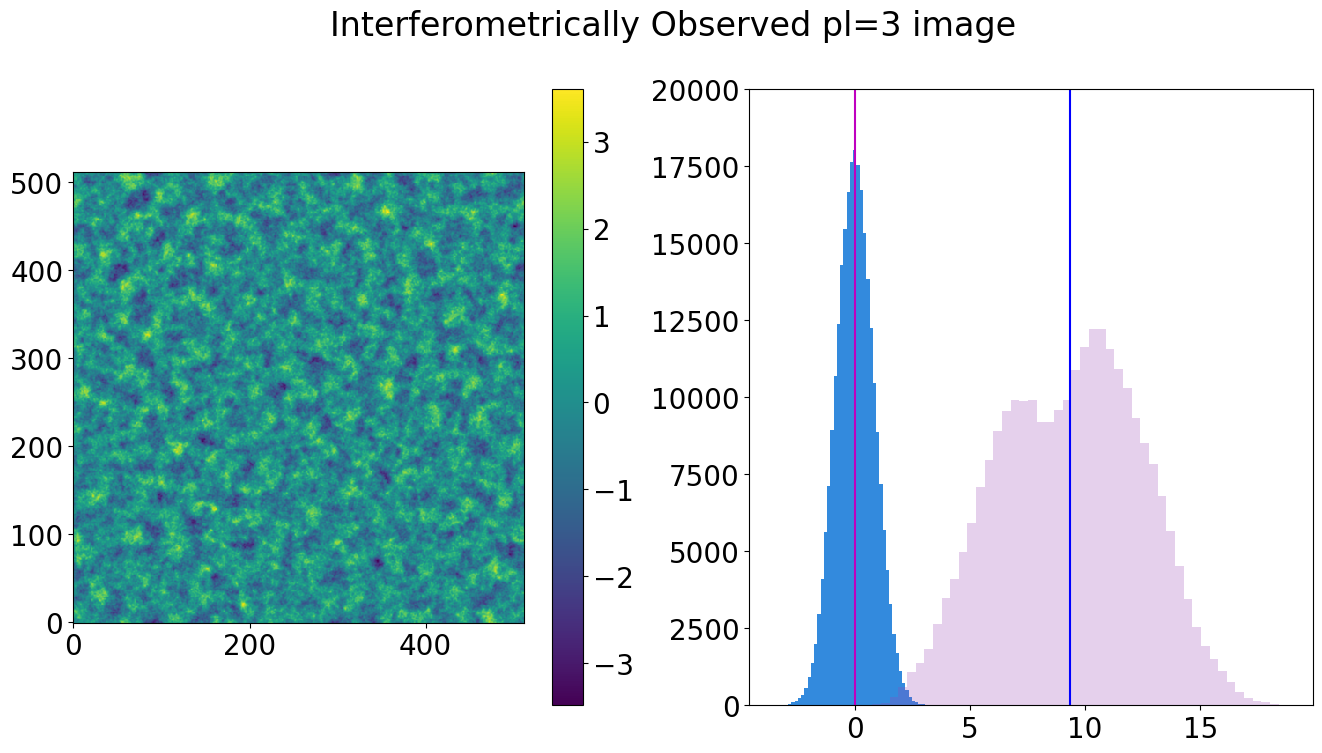

In [13]:
pl.figure(1, figsize=(16,8)).clf()
pl.subplot(1,2,1)
pl.imshow(im_interferometered.real, cmap='viridis')
pl.colorbar()
pl.suptitle(f"Interferometrically Observed pl={powerlaw} image")
pl.subplot(1,2,2)
pl.hist(im_interferometered.real.ravel(), bins=50)
mean_in = im.mean()
mean_out = im_interferometered.real.mean()
pl.vlines([mean_in], 0, 25000, color='b')
pl.vlines([mean_out], 0, 25000, color='m')
pl.hist(im.ravel(), bins=50, alpha=0.25)
pl.ylim(0,20000)
pl.savefig(f"interf_image_pl{powerlaw}.png")

The residual of the original image minus the interferometrically observed image.  The large scales and noise are preserved.

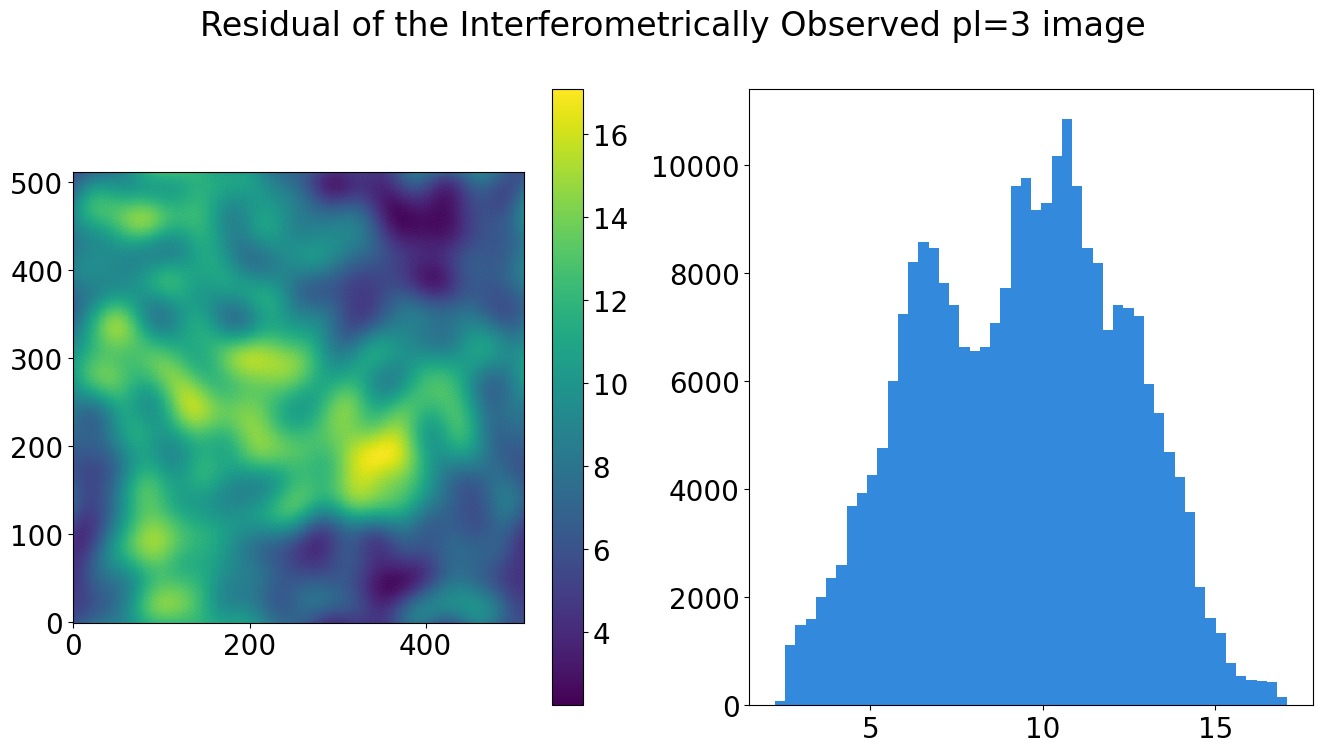

In [14]:
pl.figure(1, figsize=(16,8)).clf()
pl.subplot(1,2,1)
pl.imshow(im-im_interferometered.real, cmap='viridis')
pl.colorbar()
pl.suptitle(f"Residual of the Interferometrically Observed pl={powerlaw} image")
pl.subplot(1,2,2)
pl.hist((im-im_interferometered.real).ravel(), bins=50)
pl.savefig(f"interf_image_pl{powerlaw}_residual.png")

## Not _quite_ realistic

This synthetic interferometer map is a "perfect" interferometer image, which is not quite analogous to images produced by CASA, AIPS, etc.  The CLEAN algorithm, while mostly intended to remove PSF artifacts from the data, also adds some power into the short spacings.

### Synthetic Single Dish ###
The single dish map is just a convolution of the original data with a Gaussian beam.  It preserves flux but loses small scales.

In [15]:
# create the single-dish map by convolving the image with a FWHM=40" kernel
# (this interpretation is much easier than the sharp-edged stuff in fourier
# space because the kernel is created in real space)
lowresfwhm = 40*u.arcsec
singledish_kernel = convolution.Gaussian2DKernel(lowresfwhm/pixscale/(8*np.log(2))**0.5,
                                                 x_size=im.shape[1], y_size=im.shape[0])
singledish_kernel_fft = np.fft.fft2(singledish_kernel)
singledish_im = convolution.convolve_fft(im,
                                         kernel=singledish_kernel,
                                         boundary='fill',
                                         fill_value=im.mean())

The single-dish image and its histogram

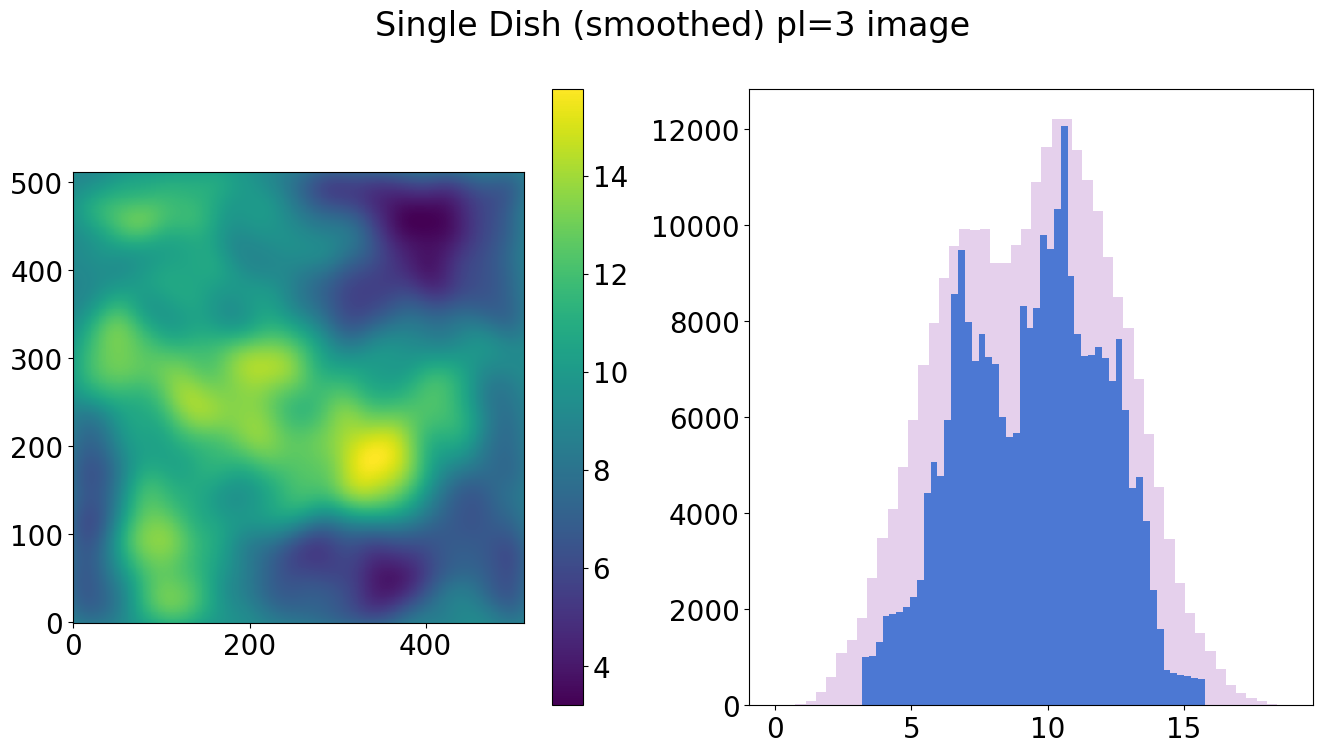

In [16]:
pl.figure(1, figsize=(16,8)).clf()
pl.subplot(1,2,1)
pl.imshow(singledish_im, cmap='viridis')
pl.colorbar()
pl.subplot(1,2,2)
pl.hist(singledish_im.ravel(), bins=50)
pl.hist(im.ravel(), bins=50, alpha=0.25)
pl.suptitle(f"Single Dish (smoothed) pl={powerlaw} image")
pl.savefig(f"singledish_image_pl{powerlaw}.png")

### The single dish in Fourier space ###
We show the single dish beam in Fourier space with the interferometer coverage range overlaid

In [17]:
pl.cm.gray.set_under((0,0,0))
pl.cm.gray.set_bad((0,0,0))

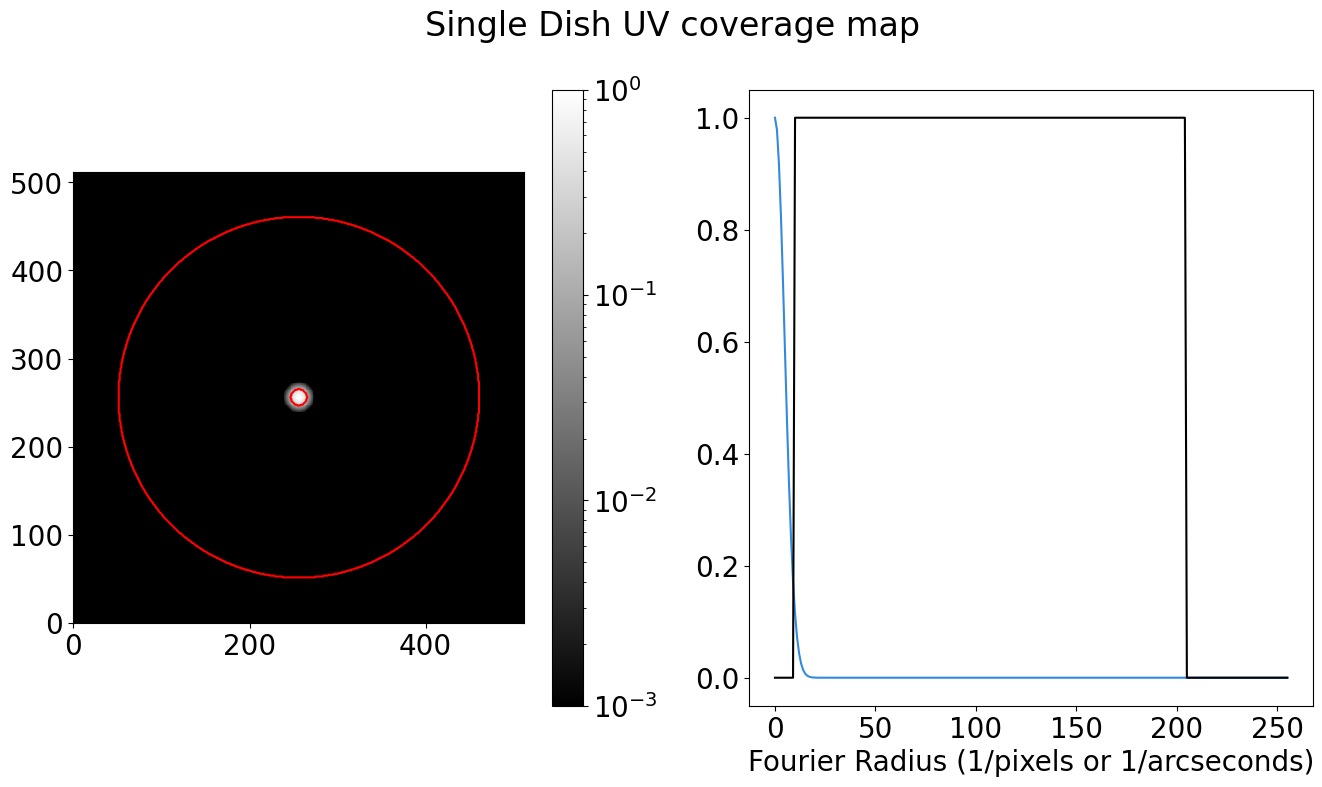

In [19]:
pl.figure(1, figsize=(16,8)).clf()
pl.subplot(1,2,1)
pl.imshow(np.fft.fftshift(np.abs(singledish_kernel_fft)), cmap=pl.cm.gray,
          norm=pl.matplotlib.colors.LogNorm(vmin=1e-3),
         )
pl.colorbar()
pl.contour(ring, levels=[0.5], colors=['r','r'])
pl.suptitle("Single Dish UV coverage map")
pl.subplot(1,2,2)
pl.plot(np.fft.fftshift(np.abs(singledish_kernel_fft))[int(im.shape[0]/2),int(im.shape[0]/2):])
pl.plot(ring[int(im.shape[0]/2),int(im.shape[0]/2):], color='k')
pl.xlabel("Fourier Radius (1/pixels or 1/arcseconds)")
pl.savefig("singledish_uvcoverage.png")

## Feathering ##
Feathering is the combination of the single-dish image with the interferometric image in the UV domain.

In the ``uvcombine`` package, this is handled by [``uvcombine.feather_simple``](https://github.com/radio-astro-tools/uvcombine/blob/master/uvcombine/uvcombine.py#L751).  However, we show the components of that function here.

For comparison, CASA's feather takes these inputs (https://casa.nrao.edu/casadocs/casa-5.6.0/global-task-list/task_feather/about):
```
#  feather :: Combine two images using their Fourier transforms
imagename           =         ''        #  Name of output feathered image
highres             =         ''        #  Name of high resolution (interferometer) image
lowres              =         ''        #  Name of low resolution (single dish) image
sdfactor            =        1.0        #  Scale factor to apply to Single Dish image
effdishdiam         =       -1.0        #  New effective SingleDish diameter to use in m
lowpassfiltersd     =      False        #  Filter out the high spatial frequencies of the SD image
```

## ASIDE: Proof that CASA's feather and uvcombine's feather do the same thing

In [20]:
from uvcombine.tests import path
from astropy.io import fits
from casatasks import feather, importfits

sdfactor = 1
lowpassfilterSD = False

input_hires = path('input_image_sz512as_pl1.5_fwhm2as_scale1as_intf2to40as.fits')
input_lores = path('input_image_sz512as_pl1.5_fwhm2as_scale1as_sd33as.fits')
output = path(f'casafeathered_sz512as_pl1.5_fwhm2as_scale1as_intf2to40as_w_sd33as_sdf={sdfactor}_lowpass={lowpassfilterSD}.image')

importfits(fitsimage=input_hires, imagename=input_hires.replace(".fits",".image"), overwrite=True)
importfits(fitsimage=input_lores, imagename=input_lores.replace(".fits",".image"), overwrite=True)

inhi = fits.getdata(input_hires)
inlo = fits.getdata(input_lores)

measures data is not available



data_update: path must exist as a directory and it must be owned by the user, path = /Users/adam/.casa/data


The expected casa data was not found at measurespath. CASA may still work if the data can be found in datapath.
The expected measures data was not found at measurespath. CASA may still work if the data can be found in datapath.
visit https://casadocs.readthedocs.io/en/stable/notebooks/external-data.html for more information

2024-11-02 20:56:16	SEVERE	::casa	
2024-11-02 20:56:16	SEVERE	::casa	data_update: path must exist as a directory and it must be owned by the user, path = /Users/adam/.casa/data
2024-11-02 20:56:16	SEVERE	::casa	
2024-11-02 20:56:16	SEVERE	::casa	Warning: measurespath must exist as a directory and it must be owned by the user.
2024-11-02 20:56:16	SEVERE	::casa	Warning: no auto update is possible on this measurespath by this user.
2024-11-02 20:56:16	SEVERE	::casa	
2024-11-02 20:56:16	SEVERE	::casa	The expected casa data was not found at measurespath. CASA m

AutoUpdatesNotAllowed: data_update: path must exist as a directory and it must be owned by the user, path = /Users/adam/.casa/data

In [ ]:
pl.figure(figsize=(12,6))
ax1=pl.subplot(1,2,1)
ax1.imshow(inhi)
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax2=pl.subplot(1,2,2)
ax2.imshow(inlo)
ax2.set_xticklabels([])
ax2.set_yticklabels([])
_=ax1.set_title("Interferometer")
_=ax2.set_title("Single-Dish")

In [ ]:
from casatasks import feather
from casatools import image
ia = image()

In [ ]:
feather(imagename=output,
        highres=input_hires.replace(".fits",".image"),
        lowres=input_lores.replace(".fits",".image"),
        sdfactor=sdfactor,
        lowpassfiltersd=lowpassfilterSD,
       )

_ = ia.open(output)
_ = casa_feather_data = ia.getchunk()
_ = ia.close()

In [ ]:
pl.imshow(casa_feather_data.squeeze().T)
pl.title("CASA Feather")
_ = pl.gca().set_xticklabels([])
_ = pl.gca().set_yticklabels([])

In [ ]:
from uvcombine import feather_simple
feathered_hdu = feather_simple(hires=input_hires,
                               lores=input_lores,
                               lowresscalefactor=sdfactor,
                               lowpassfilterSD=lowpassfilterSD,
                               return_hdu=True)

In [ ]:
pl.imshow(feathered_hdu.data)
pl.title("uvcombine Feather")
_ = pl.gca().set_xticklabels([])
_ = pl.gca().set_yticklabels([])

In [ ]:
vmin = feathered_hdu.data.min()
vmax = feathered_hdu.data.max()
_ = ax1 = pl.subplot(1,3,1)
_ = ax1.imshow(feathered_hdu.data, vmin=vmin, vmax=vmax)
_ = ax1.set_title("uvcombine Feather")
_ = ax1.set_xticklabels([])
_ = ax1.set_yticklabels([])

_ = ax2 = pl.subplot(1,3,2)
_ = ax2.imshow(casa_feather_data.squeeze().T, vmin=vmin, vmax=vmax)
_ = ax2.set_title("CASA Feather")
_ = ax2.set_xticklabels([])
_ = ax2.set_yticklabels([])

_ = ax3 = pl.subplot(1,3,3)
_ = ax3.imshow(feathered_hdu.data - casa_feather_data.squeeze().T, vmin=vmin, vmax=vmax)
_ = ax3.set_title("Difference")
_ = ax3.set_xticklabels([])
_ = ax3.set_yticklabels([])

First, we define the FWHM of the low-resolution (single-dish) image, which defines the effective cutoff point between the interferometer and the single dish.  `lowresfwhm` is equivalent to `effdishdiam` from CASA, albeit in different units.

The kernels are weight arrays for the single-dish and interferometer data.  They are the fourier transforms of the low-resolution beam and (1-that kernel), respectively.

In [ ]:
# pixel scale can be interpreted as "arcseconds"
# then, fwhm=40 means a beam fwhm of 40"
pixscale = 1*u.arcsec
lowresfwhm = 40*u.arcsec
nax1,nax2 = im.shape
kfft, ikfft = feather_kernel(nax2, nax1, lowresfwhm, pixscale,)

The weight functions for the single-dish image (blue; usually not applied) and the interferometer image (purple).  The weighting function is defined entirely by the single dish beam profile.

In [ ]:
#plot the weight functions
x,y = psds.pspec(np.fft.fftshift(kfft.real))
x = x[y==y]
y = y[y==y]
pl.semilogx(x, y)

x,y = psds.pspec(np.fft.fftshift(ikfft.real))
x = x[y==y]
y = y[y==y]
pl.semilogx(x, y)

_=pl.ylim(0, 1.1)
_=pl.xlabel("Frequency")
_=pl.ylabel("Weight")

Then we specify a few parameters that are not all available in CASA.  CASA's `lowpassfiltersd` is equivalent to our `replace_hires`, and their `sdfactor` is our `lowresscalefactor`.  The other parameters, `highresscalefactor`, `lowpassfilterSD`, and `deconvSD` are unavailable in CASA.

In [ ]:
# Feather the interferometer and single dish data back together
# This uses the naive assumptions that CASA uses
# However, there are a few flags that can be played with.
# None of them do a whole lot, though there are good theoretical
# reasons to attempt them.
im_hi = im_interferometered.real
im_low = singledish_im
lowresscalefactor=1
replace_hires = False
lowpassfilterSD = False
deconvSD = False
highresscalefactor=1
fftsum, combo = fftmerge(kfft, ikfft, im_hi*highresscalefactor,
                         im_low*lowresscalefactor,
                         replace_hires=replace_hires,
                         lowpassfilterSD=lowpassfilterSD,
                         deconvSD=deconvSD,
                        )

The feathered data set looks pretty good.

In [ ]:
# Feathered dataset
pl.figure(1, figsize=(16,8)).clf()
pl.subplot(1,2,1)
pl.imshow(combo.real, cmap='viridis')
pl.colorbar()
pl.suptitle(f"Feathered (singledish 40arcsec+interferometer) pl={powerlaw} image")
pl.subplot(1,2,2)
pl.hist(combo.real.ravel(), bins=50)
pl.hist(im.ravel(), bins=50, alpha=0.25)
pl.savefig(f"feathered_image_pl{powerlaw}.png")

This image looks pretty close to the original, but the peaks and valleys are not recovered (the contrast is reduced compared to the original).

We then compare the feathered data to the input image.

In [ ]:
# Feathered dataset
pl.figure(1, figsize=(16,8)).clf()
pl.subplot(1,2,1)
pl.imshow(combo.real, cmap='viridis')
pl.colorbar()
pl.title(f"Feathered\n(singledish 40arcsec+interferometer)\npl={powerlaw} image")
pl.subplot(1,2,2)
pl.imshow(im, cmap='viridis')
pl.colorbar()
_=pl.title(f"Input pl={powerlaw} image")

The difference between the input image and the feathered image shows the remainder artifacts.

In [ ]:
# Residuals (original minus feathered)
pl.figure(1, figsize=(16,8)).clf()
pl.subplot(1,2,1)
pl.imshow(im-combo.real, cmap='viridis')
pl.colorbar()
pl.suptitle(f"Residual Input-Feathered (singledish 40arcsec+interferometer) pl={powerlaw} image")
pl.subplot(1,2,2)
pl.hist((im-combo.real).ravel(), bins=50)
pl.savefig(f"residual_feathered_image_pl{powerlaw}.png")

If we repeat the same experiment again, but with the shortest baseline at 12m instead of 9m, the results are noticeably worse:

In [ ]:
largest_scale = 42.*u.arcsec # (1.22 * 2*u.mm/(12*u.m)).to(u.arcsec, u.dimensionless_angles())
smallest_scale = 2.5*u.arcsec
image_scale = im.shape[0]*pixscale # assume symmetric (default=256)
ring = (rr>=(image_scale/largest_scale)) & (rr<=(image_scale/smallest_scale))

In [ ]:
# create the interferometric map by removing both large and small angular
# scales in fourier space
imfft = np.fft.fft2(im)
imfft_interferometered = imfft * np.fft.fftshift(ring)
im_interferometered = np.fft.ifft2(imfft_interferometered)

In [ ]:
im_hi = im_interferometered.real
lowresscalefactor=1
replace_hires = False
lowpassfilterSD = False
deconvSD = False
highresscalefactor=1
fftsum, combo = fftmerge(kfft, ikfft, im_hi*highresscalefactor,
                         im_low*lowresscalefactor,
                         replace_hires=replace_hires,
                         lowpassfilterSD=lowpassfilterSD,
                         deconvSD=deconvSD,
                        )

The feathered image with 12m shortest baselines instead of 9m

In [ ]:
# Feathered dataset
pl.figure(1, figsize=(16,8)).clf()
pl.subplot(1,2,1)
pl.imshow(combo.real, cmap='viridis')
pl.colorbar()
pl.suptitle(f"Feathered (singledish 40arcsec+interferometer) pl={powerlaw:0.1f} image")
pl.subplot(1,2,2)
pl.hist(combo.real.ravel(), bins=50)
pl.hist(im.ravel(), bins=50, alpha=0.25)
pl.savefig(f"feathered_image_pl{powerlaw:0.1f}_12mshort.png")

The side-by-side images comparison again, but with 12m instead of 9m shortest baselines

In [ ]:
# Feathered dataset
pl.figure(1, figsize=(16,8)).clf()
pl.subplot(1,2,1)
pl.imshow(combo.real, cmap='viridis')
pl.colorbar()
pl.title(f"Feathered\n(singledish 40arcsec+interferometer)\npl={powerlaw:0.1f} image")
pl.subplot(1,2,2)
pl.imshow(im, cmap='viridis')
pl.colorbar()
_=pl.title(f"Input pl={powerlaw:0.1f} image")

The difference image (original - feathered w/12m shortest baselines)

In [ ]:
# Residuals (original minus feathered)
pl.figure(1, figsize=(16,8)).clf()
pl.subplot(1,2,1)
pl.imshow(im-combo.real, cmap='viridis')
pl.colorbar()
pl.suptitle(f"Residual Input-Feathered (singledish 40arcsec+interferometer) pl={powerlaw:0.1f} image")
pl.subplot(1,2,2)
pl.hist((im-combo.real).ravel(), bins=50)
pl.savefig(f"residual_feathered_image_pl{powerlaw:0.1f}.png")

It is more helpful to look at the difference in power spectra.  Note that the axes are log-scaled.

In [ ]:
x,y = psds.pspec(np.fft.fftshift(np.abs(np.fft.fft2(im)**2)), binsize=1.5)
x = x[y==y]
y = y[y==y]
pl.loglog(x, y, label="Input image")

x,y = psds.pspec(np.fft.fftshift(np.abs(np.fft.fft2(combo.real)**2)), binsize=1.5)
x = x[y==y]
y = y[y==y]
pl.loglog(x, y, label="Feathered image")

x,y = psds.pspec(np.fft.fftshift(np.abs(np.fft.fft2(im-combo.real)**2)), binsize=1.5)
x = x[y==y]
y = y[y==y]
pl.loglog(x, y, label="Residual")

pl.xlabel("Frequency (1/pixel)")
pl.ylabel("Power")
pl.legend(loc='best')
_=pl.ylim(1e3, 1e11)

The components that go in to the feather can help clarify the picture

In [ ]:
x,y = psds.pspec(np.fft.fftshift(np.abs(np.fft.fft2(im)**2)))
x = x[y==y]
y = y[y==y]
pl.loglog(x, y, label="Input image")

x,y = psds.pspec(np.fft.fftshift(np.abs(np.fft.fft2(im_low)**2)))
x = x[y==y]
y = y[y==y]
pl.loglog(x, y, label="Single Dish image")

x,y = psds.pspec(np.fft.fftshift(np.abs(np.fft.fft2(im_hi)**2)))
x = x[y==y]
y = y[y==y]
pl.loglog(x, y, label="Interferometer image")

pl.xlabel("Frequency (1/pixel)")
pl.ylabel("Power")
pl.legend(loc='best')
_=pl.ylim(1e3, 1e11)

Different combinations of parameters can yield very different results.

We have 8 parameter combinations: 
 
 * Replace singledish-interferometer overlap w/interferometer, or average them
 * Filter out the small angular scales from the single dish or don't
 * Deconvolve the single dish (direct deconvolution) or don't

### Replace vs Average

``replace_hires`` in uvcombine, ``lowpassfiltersd`` in CASA

This approach may be useful if there is a lot of overlap between the interferometer & single-dish and the interferometer image is considered much more reliable.

### Replace vs Average

In [ ]:
ax1 = pl.subplot(1,2,1)
ax1.set_title("Weight the interferometer")
#x,y = psds.pspec(np.fft.fftshift(kfft.real))
#x = x[y==y]
#y = y[y==y]
#pl.semilogx(x, y, linewidth=2)

x,y = psds.pspec(np.fft.fftshift(ikfft.real))
x = x[y==y]
y = y[y==y]
pl.semilogx(x, y, linewidth=2)

_=pl.ylim(0, 1.1)
_=pl.xlabel("Frequency")
_=pl.ylabel("Weight")

ax2 = pl.subplot(1,2,2)
ax2.set_title("Replace Data")
ax2.semilogx(x, y < 0.99, linewidth=4)
ax2.semilogx(x, y > 0.99, linewidth=2)

_=pl.ylim(-0.1, 1.1)
_=pl.xlabel("Frequency")
_=pl.ylabel("Weight")

### Filter out the small angular scales from the single dish or don't

``lowpassfilterSD`` in uvcombine, unavailable in CASA.

The filter function for the single-dish is usually not applied, as it is assumed to have already been applied during the observation (the filter function _is_ the single dish PSF / main beam).

### Filter out the small angular scales from the single dish or don't

In [ ]:
ax1 = pl.subplot(1,2,1)
ax1.set_title("Weight only the interferometer")

x,y = psds.pspec(np.fft.fftshift(ikfft.real))
x = x[y==y]
y = y[y==y]
pl.semilogx(x, y, linewidth=2)

_=pl.ylim(0, 1.1)
_=pl.xlabel("Frequency")
_=pl.ylabel("Weight")

ax2 = pl.subplot(1,2,2)
ax2.set_title("Weight both")
x,y = psds.pspec(np.fft.fftshift(kfft.real))
x = x[y==y]
y = y[y==y]
pl.semilogx(x, y, linewidth=2)

x,y = psds.pspec(np.fft.fftshift(ikfft.real))
x = x[y==y]
y = y[y==y]
pl.semilogx(x, y, linewidth=2)



_=pl.ylim(-0.1, 1.1)
_=pl.xlabel("Frequency")
_=pl.ylabel("Weight")

### Deconvolve the single dish (direct deconvolution) or don't

``deconvSD`` in uvcombine, unavailable in CASA

Perhaps the most relevant parameter, one can deconvolve the single-dish data prior to deconvolution.  This approach is a direct, frequency-space deconvolution, i.e., the data are divided by the kernel in the fourier domain.

Direct deconvolution is problematic, as we are trying to undo a multiply-by-zero operation with a divide-by-zero operation; as a result, the deconvolution diverges at high frequencies (small scales).  We therefore do not include data below the ``min_beam_fraction=0.1`` by default.

AFAIK, this method is unavailable in CASA's ``feather`` task, but it appears to be available in the C code using something called ``GaussianDeconvolver`` (see an old blog post, http://keflavich.github.io/blog/what-does-feather-do.html ).

### Deconvolve the single dish (direct deconvolution) or don't

In [ ]:
x,y = psds.pspec(np.fft.fftshift(kfft.real))
x = x[y==y]
y = y[y==y]
pl.loglog(x, y, linewidth=4, alpha=0.5, label="Single Dish Kernel")

cutoff_x = x[np.argmin(np.abs(y-0.1))]

x,y = psds.pspec(np.fft.fftshift(np.abs(np.fft.fft2(singledish_im)**2)))
x = x[y==y]
y = y[y==y]
pl.loglog(x, y, linewidth=2, label="Single Dish Image")


x,y = psds.pspec(np.abs(np.fft.fftshift(np.fft.fft2(singledish_im) / kfft.real)**2))
x = x[y==y]
y = y[y==y]
pl.loglog(x, y, linewidth=2, label="Single Dish Deconvolved")

x,y = psds.pspec(np.abs(np.fft.fftshift(np.fft.fft2(im))**2))
x = x[y==y]
y = y[y==y]
pl.loglog(x, y, linewidth=2, label="Original Image", zorder=-5, linestyle=':')


pl.vlines(cutoff_x, 1e-3, 1e14, color='k', linestyle='--')


_=pl.ylim(1e-3, 1e14)
pl.legend(loc='upper right')
_=pl.xlabel("Frequency")
_=pl.ylabel("Power")

The next slides are a walkthrough of parameter exploration with different effective dish sizes.

First, we have a 12m single-dish combined with an interferometer with shortest baseline length of 12m.

In [ ]:
from uvcombine.plot_utilities import compare_parameters_feather_simple, compare_feather_weights

for largest_scale, name in zip((42,56)*u.arcsec, ('_12mLAS', '_9mLAS')):
    for lowresfwhm, lrname in zip((20,40)*u.arcsec, ("_20asSD", "_40asSD")):

        smallest_scale = 2.5*u.arcsec
        pixscale = 1*u.arcsec
        image_scale = im.shape[0]*pixscale # assume symmetric (default=256)
        ring = (rr>=(image_scale/largest_scale)) & (rr<=(image_scale/smallest_scale))

        imfft = np.fft.fft2(im)
        imfft_interferometered = imfft * np.fft.fftshift(ring)
        im_interferometered = np.fft.ifft2(imfft_interferometered).real

        singledish_im = convolution.convolve_fft(im,
                                                 convolution.Gaussian2DKernel((lowresfwhm/pixscale)/np.sqrt(8*np.log(2))),
                                                 boundary='fill', fill_value=im.mean())

        compare_parameters_feather_simple(im, im_hi=im_interferometered,
                                          im_low=singledish_im,
                                          suffix=name+lrname,
                                          lowresfwhm=lowresfwhm, pixscale=pixscale,                                        
                                          psd_axlims=(1e-3,1,80,5e5),
                                         )

<img src=parameter_comparison_images_12mLAS_40asSD.png style="height: 600px">

<img src=parameter_comparison_residuals_12mLAS_40asSD.png style="height: 600px">

Residuals are in blue.

<img src=parameter_comparison_powerspectra_12mLAS_40asSD.png style="height: 600px">

A short-spacing limit of 12m for the interferometer and dish size of 12m is a bad case, but not the worst.

ALMA's shortest baselines are 14.6m (main array) and 8.7m (7m array).  L05, the 5th percentile baseline length, is 21.4m (9.1m) for the 12m (7m) array.

A realistic case for ALMA is then a 9m shortest baseline and a 12m effective single dish.

<img src=parameter_comparison_images_9mLAS_40asSD.png style="height: 600px">

<img src=parameter_comparison_residuals_9mLAS_40asSD.png style="height: 600px">

Residuals are in blue.

<img src=parameter_comparison_powerspectra_9mLAS_40asSD.png style="height: 600px">

This realistic case is still bad.  The "best case", in which we have good UV overlap (e.g., a 24m dish instead of a 12m), actually can get good theoretical recovery

<img src=parameter_comparison_images_9mLAS_20asSD.png style="height: 600px">

<img src=parameter_comparison_residuals_9mLAS_20asSD.png style="height: 600px">

Residuals are in blue.

<img src=parameter_comparison_powerspectra_9mLAS_20asSD.png style="height: 600px">

CASA's default parameters are fine, but for best performance, the single-dish image should be deconvolved.

The appropriate choice of feather parameters depends (mildly) on the UV overlap:

 * If the single dish is substantially bigger than the shortest baseline, CASA's defaults or replacing short-spacing with deconvolved single-dish both work well
 * If the single dish is comparable to the shortest baseline, the best results come from deconvolving the single-dish data and weighted-averaging them with the interferometric

These feather experiments represent the absolute best-case scenario.  They should be used as references for comparison with any other combination technique.

## Non-ideal cases

Besides simple UV coverage problems (which are expensive to fix and usually out of our control), there are other issues:

 * Relative calibration
 * Relative sensitivity

Relative calibration is an issue if the data simply aren't calibrated perfectly (systematic uncertainties are usually 5-15%) or if the single-dish data come from a different frequency range (e.g., using wide-band bolometer data to fill in the continuum zero-spacing).

Uncertainties in the "scale factor" and in the beam size of factors of 2-3 are _realistic_: for example, SCUBA on the JCMT at 450 $\mu$m has a very uncertain error beam (http://adsabs.harvard.edu/abs/2018ApJ...853..171G).

<img src="scuba_feather_scalefactor_comparison.png" style="">

We can simulate calibration error using the `highresscalefactor` and `lowresscalefactor` parameters, which are included to correct for these errors

In [ ]:
lowresscalefactor = 1.50
highresscalefactor = 1.0
fftsum, combo = fftmerge(kfft/lowresscalefactor, ikfft, im_hi*highresscalefactor,
                         im_low*lowresscalefactor,
                         replace_hires=replace_hires,
                         lowpassfilterSD=lowpassfilterSD,
                         deconvSD=deconvSD,
                        )

In [ ]:
x,y = psds.pspec(np.fft.fftshift(np.abs(np.fft.fft2(im)**2)))
x = x[y==y]
y = y[y==y]
pl.loglog(x, y, label="Input image")

x,y = psds.pspec(np.fft.fftshift(np.abs(np.fft.fft2(combo.real)**2)))
x = x[y==y]
y = y[y==y]
pl.loglog(x, y, label="Feathered image (SD$\\times$1.5)")

x,y = psds.pspec(np.fft.fftshift(np.abs(np.fft.fft2(im-combo.real)**2)))
x = x[y==y]
y = y[y==y]
pl.loglog(x, y, label="Residual")

pl.legend(loc='best')
_=pl.ylim(1e3, 1e14)

In [ ]:
# Feathered dataset
pl.figure(1, figsize=(20,8)).clf()
pl.subplot(1,3,1)
pl.imshow(combo.real, cmap='viridis')
pl.colorbar()
pl.title("Feathered w/50%\ntoo-bright\nsingle-dish")
pl.subplot(1,3,2)
pl.imshow(im, cmap='viridis')
pl.colorbar()
_=pl.title(f"Input pl={powerlaw:0.1f} image")
pl.subplot(1,3,3)
pl.imshow(im-combo.real, cmap='viridis')
pl.colorbar()
_=pl.title("Residual")

In [ ]:
lowresscalefactor = 1.0
highresscalefactor = 1.50
fftsum, combo = fftmerge(kfft, ikfft, im_hi*highresscalefactor,
                         im_low*lowresscalefactor,
                         replace_hires=replace_hires,
                         lowpassfilterSD=lowpassfilterSD,
                         deconvSD=deconvSD,
                        )

In [ ]:
x,y = psds.pspec(np.fft.fftshift(np.abs(np.fft.fft2(im)**2)))
x = x[y==y]
y = y[y==y]
pl.loglog(x, y, label="Input image")

x,y = psds.pspec(np.fft.fftshift(np.abs(np.fft.fft2(combo.real)**2)))
x = x[y==y]
y = y[y==y]
pl.loglog(x, y, label="Feathered image (intf$\\times$1.5)")

x,y = psds.pspec(np.fft.fftshift(np.abs(np.fft.fft2(im-combo.real)**2)))
x = x[y==y]
y = y[y==y]
pl.loglog(x, y, label="Residual")

pl.legend(loc='best')
_=pl.ylim(1e3, 1e13)

In [ ]:
# Feathered dataset
pl.figure(1, figsize=(20,8)).clf()
pl.subplot(1,3,1)
pl.imshow(combo.real, cmap='viridis')
pl.colorbar()
pl.title("Feathered w/50%\ntoo-bright\ninterferometer")
pl.subplot(1,3,2)
pl.imshow(im, cmap='viridis')
pl.colorbar()
_=pl.title(f"Input pl={powerlaw:0.1f} image")
pl.subplot(1,3,3)
pl.imshow(im-combo.real, cmap='viridis')
pl.colorbar()
_=pl.title("Residual")

## Relative sensitivity

The cases we've treated above assume that the interferometer and single-dish telescope have infinite sensitivity; the "noise" in the image is actually part of the sky.  So, what happens if we add observational (as opposed to astrophysical) noise?

In [ ]:
import radio_beam
import astropy.utils.misc
lowresscalefactor = 1.0
highresscalefactor = 1.0
sd_beam = radio_beam.Beam(lowresfwhm)
sd_beam_volume = (sd_beam.sr / pixscale**2).decompose()
noise_amplitude = 0.005
with astropy.utils.misc.NumpyRNGContext(0):
    noise_sd = convolution.convolve_fft(
        singledish_im.max() * noise_amplitude * np.random.randn(*singledish_im.shape) * sd_beam_volume,
        sd_beam.as_kernel(pixscale))
noisy_sd = (singledish_im + noise_sd)
fftsum, combo = fftmerge(kfft, ikfft, im_hi*highresscalefactor,
                         noisy_sd*lowresscalefactor,
                         replace_hires=replace_hires,
                         lowpassfilterSD=lowpassfilterSD,
                         deconvSD=deconvSD,
                        )

In [ ]:
pl.figure(1, figsize=(10,10)).clf()
ax1 = pl.subplot(2,2,1)
pl.imshow(singledish_im-singledish_im.min(), cmap='viridis')
pl.colorbar()
pl.title("Single-dish")
beam_ellipse = sd_beam.ellipse_to_plot(pixscale=pixscale, xcen=25, ycen=25)
beam_ellipse.set_facecolor('w')
ax1.add_artist(beam_ellipse)
ax2 = pl.subplot(2,2,2)
ax2im = pl.imshow(noisy_sd-singledish_im.min(), cmap='viridis')
pl.colorbar()
_=pl.title("Noisy single-dish")
ax3 = pl.subplot(2,2,3)
pl.imshow(singledish_im-noisy_sd, cmap='viridis', vmin=ax2im.get_clim()[0], vmax=ax2im.get_clim()[1])#-ax2im.get_clim()[0])
pl.colorbar()
_=pl.title("Difference\n(noise on SD beam scale)")
ax4 = pl.subplot(2,2,4)
pl.imshow((singledish_im-singledish_im.mean())/noise_sd.std(),
          cmap='viridis', interpolation='none', vmin=0, vmax=10)
pl.colorbar()
_=pl.title("SNR")
for ax in (ax1,ax2,ax3,ax4):
    _=ax.set_xticklabels([])
    _=ax.set_yticklabels([])
    

In [ ]:
x,y = psds.pspec(np.fft.fftshift(np.abs(np.fft.fft2(im)**2)))
x = x[y==y]
y = y[y==y]
pl.loglog(x, y, label="Input image", linewidth=4, alpha=0.25)

x,y = psds.pspec(np.fft.fftshift(np.abs(np.fft.fft2(singledish_im)**2)))
x = x[y==y]
y = y[y==y]
pl.loglog(x, y, label="Single-dish image")

x,y = psds.pspec(np.fft.fftshift(np.abs(np.fft.fft2(noisy_sd)**2)))
x = x[y==y]
y = y[y==y]
pl.loglog(x, y, label="Noisy single-dish image")


x,y = psds.pspec(np.fft.fftshift(np.abs(np.fft.fft2(combo.real)**2)))
x = x[y==y]
y = y[y==y]
pl.loglog(x, y, label="Feathered image")

x,y = psds.pspec(np.fft.fftshift(np.abs(np.fft.fft2(im-combo.real)**2)))
x = x[y==y]
y = y[y==y]
pl.loglog(x, y, label="Residual", linestyle=":")

pl.legend(loc='best')
_=pl.ylim(1e3, 1e13)

In [ ]:
# Feathered dataset
pl.figure(1, figsize=(20,8)).clf()
pl.subplot(1,3,1)
pl.imshow(combo.real, cmap='viridis')
pl.colorbar()
pl.title("Feathered w/noisy\nsingle-dish")
pl.subplot(1,3,2)
pl.imshow(im, cmap='viridis')
pl.colorbar()
_=pl.title(f"Input pl={powerlaw:0.1f} image")
pl.subplot(1,3,3)
pl.imshow(im-combo.real, cmap='viridis')
pl.colorbar()
_=pl.title("Residual")

Now we'll do the same experiment with noise added to the interferometric image too.

In this case, we're adding Gaussian (white) noise evenly in baseline length, which is perhaps slightly unrealistic.

SKIPPED/COMMENTED OUT: this isn't really how visibility noise works...


lowresscalefactor = 1.0
highresscalefactor = 1.0
intf_beam = radio_beam.Beam(u.Quantity(smallest_scale, u.arcsec))
intf_beam_volume = (intf_beam.sr / pixscale**2).decompose()
assert intf_beam_volume < 100
noise_amplitude_intf = 0.05
with astropy.utils.misc.NumpyRNGContext(0):
    noise_intf = convolution.convolve_fft(
        im_interferometered.real.max() * noise_amplitude_intf * np.random.randn(*im_interferometered.shape) * intf_beam_volume,
        intf_beam.as_kernel(pixscale))
noisy_intf = (im_interferometered.real + noise_intf)
fftsum, combo = fftmerge(kfft, ikfft, noisy_intf*highresscalefactor,
                         noisy_sd*lowresscalefactor,
                         replace_hires=replace_hires,
                         lowpassfilterSD=lowpassfilterSD,
                         deconvSD=deconvSD,
                        )

In [ ]:
lowresscalefactor = 1.0
highresscalefactor = 1.0
intf_beam = radio_beam.Beam(u.Quantity(smallest_scale, u.arcsec))
intf_beam_volume = (intf_beam.sr / pixscale**2).decompose()
assert intf_beam_volume < 100
noise_amplitude_intf = 0.0005
with astropy.utils.misc.NumpyRNGContext(0):
    noise_intf = np.fft.fftshift(np.fft.fft2(
        im_interferometered.real.max() * noise_amplitude_intf * np.random.randn(*im_interferometered.shape) * intf_beam_volume
        * np.fft.fftshift(ring)).real)
noisy_intf = (im_interferometered.real + noise_intf)
fftsum, combo = fftmerge(kfft, ikfft, noisy_intf*highresscalefactor,
                         noisy_sd*lowresscalefactor,
                         replace_hires=replace_hires,
                         lowpassfilterSD=lowpassfilterSD,
                         deconvSD=deconvSD,
                        )

In [ ]:
pl.figure(1, figsize=(10,10)).clf()
ax1 = pl.subplot(2,2,1)
pl.imshow(im_interferometered.real, cmap='viridis')
pl.colorbar()
pl.title("Interferometer Image")

beam_ellipse = intf_beam.ellipse_to_plot(pixscale=pixscale, xcen=25, ycen=25)
beam_ellipse.set_facecolor('w')
ax1.add_artist(beam_ellipse)

ax2 = pl.subplot(2,2,2)
ax2im = pl.imshow(noisy_intf, cmap='viridis')
pl.colorbar()
_=pl.title("Noisy intf")
ax3 = pl.subplot(2,2,3)
pl.imshow(im_interferometered.real-noisy_intf, cmap='viridis')#, vmin=ax2im.get_clim()[0], vmax=ax2im.get_clim()[1])#-ax2im.get_clim()[0])
pl.colorbar()
_=pl.title("Difference\n(noise)")
ax4 = pl.subplot(2,2,4)
pl.imshow(im_interferometered.real/noise_intf.std(), cmap='viridis', interpolation='none', vmin=0, vmax=15)
pl.colorbar()
_=pl.title("SNR")
for ax in (ax1,ax2,ax3,ax4):
    _=ax.set_xticklabels([])
    _=ax.set_yticklabels([])

In [ ]:
x,y = psds.pspec(np.fft.fftshift(np.abs(np.fft.fft2(im)**2)))
x = x[y==y]
y = y[y==y]
pl.loglog(x, y, label="Input image", linewidth=4, alpha=0.25)

x,y = psds.pspec(np.fft.fftshift(np.abs(np.fft.fft2(im_interferometered)**2)))
x = x[y==y]
y = y[y==y]
pl.loglog(x, y, label="Interferometer image")

x,y = psds.pspec(np.fft.fftshift(np.abs(np.fft.fft2(noisy_intf)**2)))
x = x[y==y]
y = y[y==y]
pl.loglog(x, y, label="Noisy interferometer image")


x,y = psds.pspec(np.fft.fftshift(np.abs(np.fft.fft2(combo.real)**2)))
x = x[y==y]
y = y[y==y]
pl.loglog(x, y, label="Feathered image")

x,y = psds.pspec(np.fft.fftshift(np.abs(np.fft.fft2(im-combo.real)**2)))
x = x[y==y]
y = y[y==y]
pl.loglog(x, y, label="Residual", linestyle=":")

pl.legend(loc='best')
_=pl.ylim(1e3, 1e13)

In [ ]:
# Feathered dataset
pl.figure(1, figsize=(20,8)).clf()
pl.subplot(1,3,1)
pl.imshow(combo.real, cmap='viridis')
pl.colorbar()
pl.title("Feathered w/noisy\ndata")
pl.subplot(1,3,2)
pl.imshow(im, cmap='viridis')
pl.colorbar()
_=pl.title(f"Input pl={powerlaw:0.1f} image")
pl.subplot(1,3,3)
pl.imshow(im-combo.real, cmap='viridis')
pl.colorbar()
_=pl.title("Residual")

Finally, what happens if you assume your single-dish FWHM is smaller or larger than it really is?

In other words, what happens when you over/under weight the single-dish data?

In [ ]:
import imp
import uvcombine.plot_utilities
imp.reload(uvcombine.plot_utilities)
from uvcombine.plot_utilities import compare_parameters_feather_simple, compare_feather_weights

largest_scale = 56*u.arcsec
lowresfwhm = 20*u.arcsec

smallest_scale = 2.5*u.arcsec
pixscale = 1*u.arcsec
image_scale = im.shape[0]*pixscale # assume symmetric (default=256)
ring = (rr>=(image_scale/largest_scale)) & (rr<=(image_scale/smallest_scale))

imfft = np.fft.fft2(im)
imfft_interferometered = imfft * np.fft.fftshift(ring)
im_interferometered = np.fft.ifft2(imfft_interferometered).real

singledish_im = convolution.convolve_fft(im,
                                         convolution.Gaussian2DKernel((lowresfwhm/pixscale)/np.sqrt(8*np.log(2))),
                                         boundary='fill', fill_value=im.mean())

compare_feather_weights(im, im_hi=im_interferometered,
                        im_low=singledish_im,
                        lowresfwhm=lowresfwhm,
                        pixscale=pixscale,                                        
                        psd_axlims=(1e-3,1,80,5e5),
                       )

<img src=parameter_comparison_lowresfwhm_powerspectra.png style="height: 600px">

<img src=parameter_comparison_lowresfwhm_images.png style="height: 600px">

<img src=parameter_comparison_lowresfwhm_residuals.png style="height: 600px">

# Conclusion

Feathering is the most basic form of image combination, but it still has many adjustable parameters.

Feathering should be used as a reference when testing other techniques.

These slides, and others, can be found at https://keflavich.github.io/talks/FeatheringPresentation/